In [25]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy as sp

## Teil 1

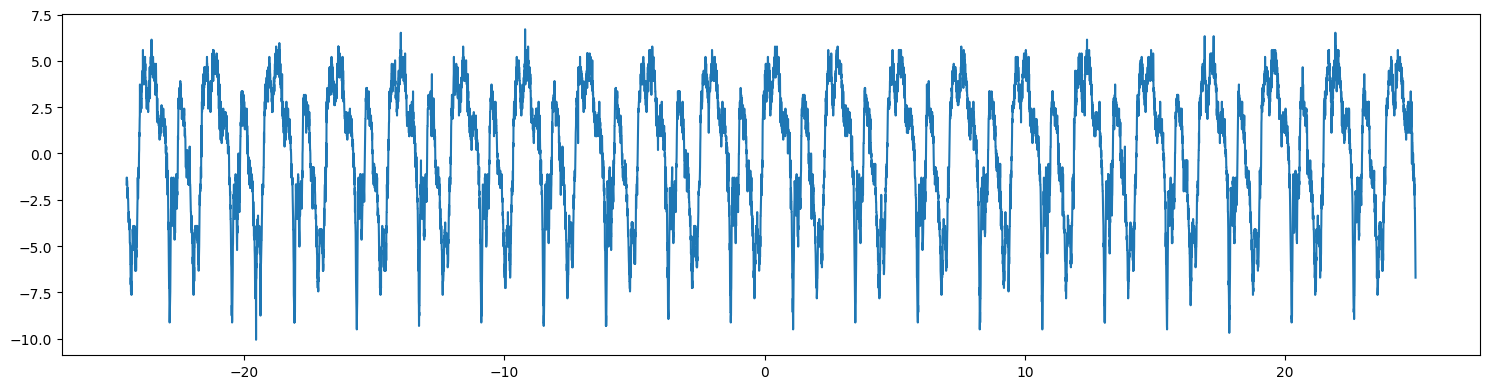

In [3]:
def readAudio(path):
    values = np.genfromtxt(fname=path,dtype=str, skip_header=103)
    valueList=[]
    for yStrings in values:
        Values=yStrings.replace(",",".").split(";")
        valueList.append(Values)
    return np.array(valueList, dtype= float)
mh4List=readAudio(path="./Files/MH4.csv")
plt.rcParams["figure.figsize"] = [15, 4]
plt.rcParams["figure.autolayout"] = True
plt.plot(mh4List[:,0],mh4List[:,1],label="Mundharmonika")


C:\Users\Felipe\Nextcloud\SSS\venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


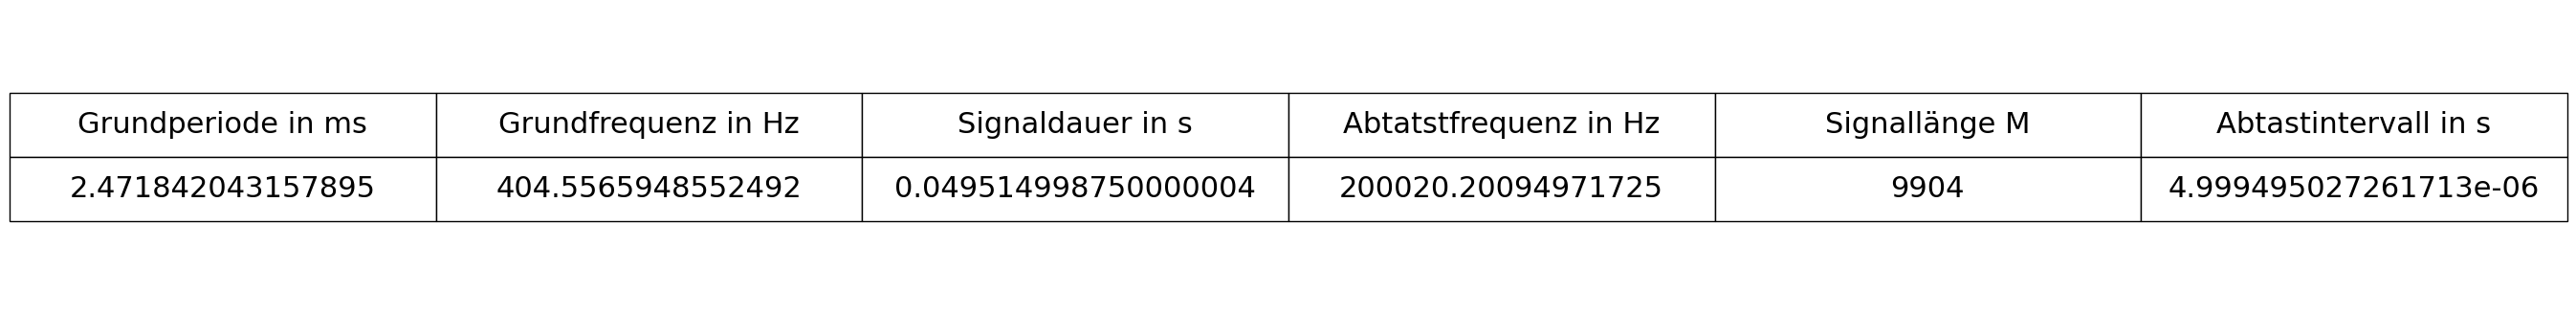

In [4]:
def minIntervall(array,start,length):
    min=[np.iinfo(np.int32).max,np.iinfo(np.int32).max]
    for i in range(start,start+length):
        if array[i,1]<min[1]:
            min=array[i]
    return min
def plotTable(array1,colLabelTupel):
    fig, ax = plt.subplots()
    ax.axis('off')
    table = ax.table(cellText=[array1], loc='center', cellLoc='center', colLabels=colLabelTupel)
    table.auto_set_font_size(False)
    table.set_fontsize(22)
    table.scale(2.3, 4)  # Adjust the size of the table
    plt.show()

firstMin=minIntervall(mh4List,0,200)
lastMin=minIntervall(mh4List,9100,len(mh4List)-9100)
grundPeriode=(lastMin[0]-firstMin[0])/19    #in ms
grundFrequenz=(1/grundPeriode)*1000         #in Hz
signalDauer=(mh4List[-1,0]-mh4List[0,0])/1000     # in s
abtastFrequenz=len(mh4List)/signalDauer     # frequenz in Hz
signalLänge=len(mh4List)
abtastIntervall=1/abtastFrequenz
plotTable([grundPeriode,grundFrequenz,signalDauer,abtastFrequenz,signalLänge,abtastIntervall],("Grundperiode in ms","Grundfrequenz in Hz","Signaldauer in s","Abtatstfrequenz in Hz","Signallänge M","Abtastintervall in s"))

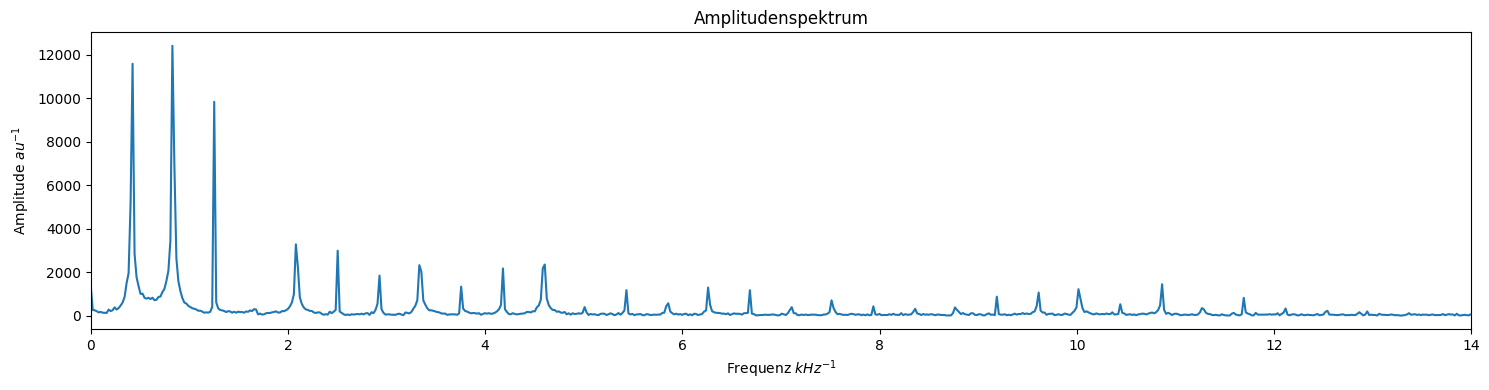

Peaks, gegeben in kHz: [ 0.828   1.2521  1.6561  2.0802  2.5043  2.9284  3.3323  3.7564  4.1806
  4.6047  5.0086  5.4327  5.8568  6.2607  6.6848  7.109   7.5129  7.937
  8.3611  8.765   9.1891  9.6132 10.0172 10.4413 10.8654 11.2693 11.6934
 12.1175 12.5417 12.9456 13.3697]


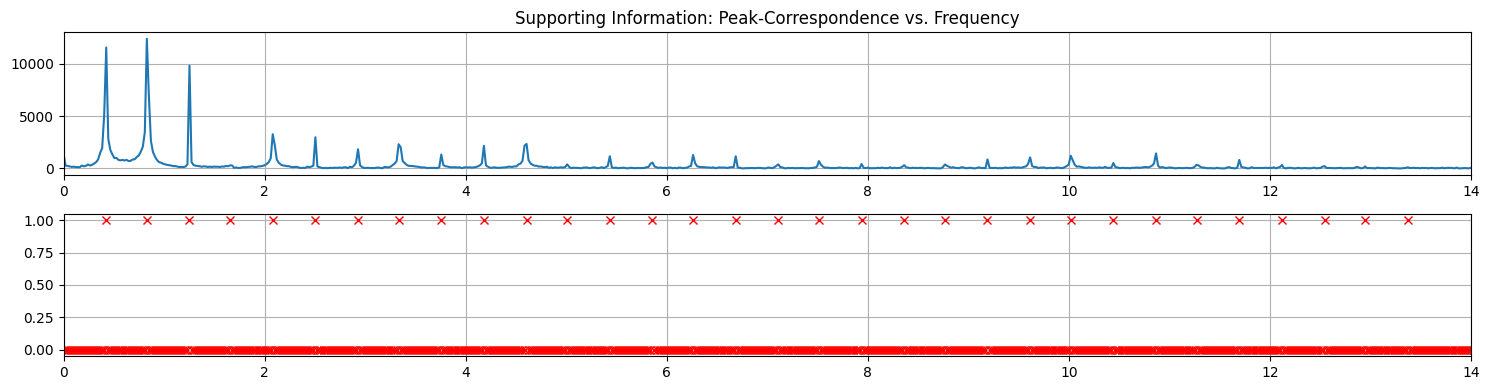

In [104]:
m_delta_t = signalLänge * abtastIntervall
corrected_freqs = []

foo_rier = np.fft.fft(mh4List, axis=0)

for i in range(len(foo_rier)):
    corrected_freqs.append((i / m_delta_t) / 1000)

plt.plot(corrected_freqs, np.abs(foo_rier[:,1]))
plt.xlim(0, 14)
plt.title("Amplitudenspektrum")
plt.xlabel("Frequenz $kHz^{-1}$")
plt.ylabel("Amplitude $au^{-1}$")
plt.show()

# Finde die Peaks
peak_indices, _ = sp.signal.find_peaks(np.abs(foo_rier[:,1]), distance=10, height=100, prominence=100)

# helper-list used to confirm the results of scipys peak-picker
why_values = np.zeros_like(corrected_freqs)
for i in range(len(why_values)):
    if i in peak_indices:
        why_values[i] = 1

# map back to corrected freqs in order to extract meaningfull information
corrected_peaks_list = []
for i in range(len(why_values)):
    if why_values[i] == 1:
        corrected_peaks_list.append(corrected_freqs[i])
corrected_peaks_list = np.array(corrected_peaks_list)

print('Peaks, gegeben in kHz:', corrected_peaks_list[1:32].round(4)) # Grundfrequenz (größter Beitrag) 1,25 kHz

# Plotte die Daten und markiere die Peaks
plt.subplot(2, 1, 1)
plt.plot(corrected_freqs, np.abs(foo_rier[:,1]))
plt.xlim(0, 14)
plt.title("Supporting Information: Peak-Correspondence vs. Frequency")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(corrected_freqs, why_values, 'x', color='red')
plt.xlim(0, 14)
plt.grid()
plt.show()

## Teil 2

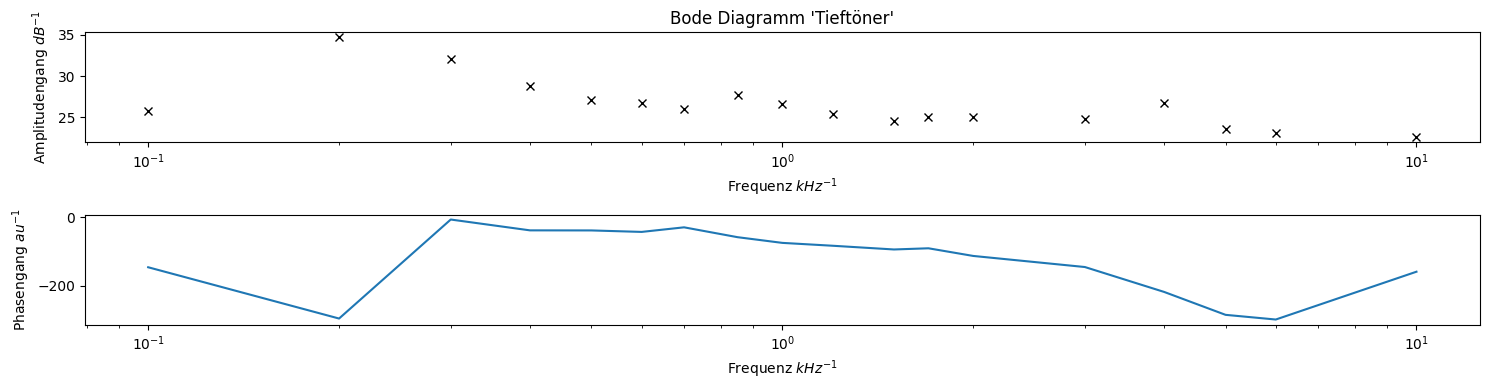

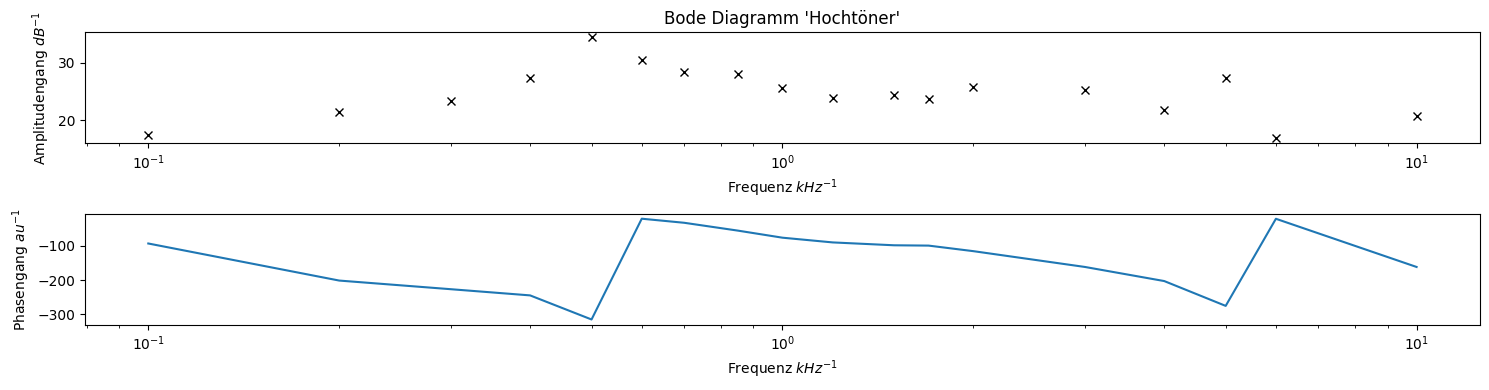

In [6]:
# kHz
freqs = [.1, .2, .3, .4, .5, .6, .7, .85, 1, 1.2, 1.5, 1.7, 2, 3, 4, 5, 6, 10]

def read_csv(path:str, col:int, start:int, stop:int):
    values = np.genfromtxt(fname=path,dtype=str, delimiter=";", usecols=(col), skip_header=start-1, max_rows=stop-start)
    valueList=[]
    for yStrings in values:
        if yStrings.endswith('s'):
            yStrings = yStrings[:-2]
        Values=yStrings.replace(",",".").split(";")
        valueList.append(Values)
    return np.array(valueList, dtype= float)

# takes time-deltas, returns phaseshifts
def delta2phase(delta_arrray, freqs_array=freqs):
    phasearray = []
    for i in range(len(delta_arrray)):
        phasearray.append(-delta_arrray[i] * 360/1000 * freqs_array[i]) # adjust powers of ten
    return phasearray

# check if phaseshift (adjustet to s) is smaller than 2pi (given in seconds also). If not returns False, prints Index.
def check_phases(delta_array, freqsarray=freqs)->bool:
    for i in range(2, len(delta_array)):
        if delta_array[i] / 1_000_000 > 1 / (freqsarray[i] * 1000):# adjust powers of ten
            print("Failed at Index " + str(i) + ": " + str(delta_array[i] / 1_000_000) + " , " + str(1 / (freqsarray[i]) * 1000))
            return False
    return True
# print(check_phases(delta_t))
# print(check_phases(delta_h))

# 'Tieftöner'
peak2peak_t = read_csv("./Files/teil2.csv", 2, 2, 20)
delta_t = read_csv("./Files/teil2.csv", 3, 2, 20)
# adapt ms -> µs
for i in range(0,2):
    delta_t[i] *= 1000
log_peak2peak_t = 20 * np.log10(peak2peak_t)

phases_t = delta2phase(delta_t)
# print(phases_t)

# 'Hochtöner'
peak2peak_h = read_csv("./Files/teil2.csv", 2, 22, 40)
delta_h = read_csv("./Files/teil2.csv", 3, 22, 40)
# adapt ms -> µs
for i in range(0,5):
    delta_h[i] *= 1000
log_peak2peak_h = 20 * np.log10(peak2peak_h)

phases_h = delta2phase(delta_h)


def plotter():
    pass

plt.subplot(2, 1, 1)
plt.title("Bode Diagramm \'Tieftöner\'")
plt.plot(freqs, log_peak2peak_t, 'xk')
plt.semilogx()
plt.xlabel("Frequenz $kHz^{-1}$")
plt.ylabel("Amplitudengang $dB^{-1}$")
# plt.show()
plt.subplot(2, 1, 2)
plt.semilogx(freqs, phases_t)
plt.xlabel("Frequenz $kHz^{-1}$")
plt.ylabel("Phasengang $au^{-1}$")
plt.show()

plt.subplot(2, 1, 1)
plt.title("Bode Diagramm \'Hochtöner\'")
plt.plot(freqs, log_peak2peak_h, 'xk')
plt.semilogx()
plt.xlabel("Frequenz $kHz^{-1}$")
plt.ylabel("Amplitudengang $dB^{-1}$")
# plt.show()
plt.subplot(2, 1, 2)
plt.semilogx(freqs, phases_h)
plt.xlabel("Frequenz $kHz^{-1}$")
plt.ylabel("Phasengang $au^{-1}$")
plt.show()